In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle


In [3]:
data = pd.read_csv('./data/Sampled_data_train.csv')
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3493085.0,0.0,13264386.0,314.950,W,1444.0,490.0,150.0,visa,166.0,...,missing,-1.0,missing,missing,missing,missing,missing,missing,missing,missing
1,3520085.0,0.0,14052685.0,117.000,W,3681.0,513.0,150.0,visa,166.0,...,missing,-1.0,missing,missing,missing,missing,missing,missing,missing,missing
2,3329023.0,0.0,8439647.0,92.745,C,3335.0,545.0,185.0,visa,138.0,...,ie 11.0 for desktop,-1.0,missing,missing,F,T,T,F,desktop,Trident/7.0
3,3408925.0,0.0,10689293.0,200.000,R,12607.0,399.0,150.0,american express,185.0,...,chrome 65.0,24.0,1600x900,match_status:2,T,F,T,F,desktop,Windows
4,3075828.0,0.0,1874266.0,226.000,W,10795.0,555.0,150.0,visa,226.0,...,missing,-1.0,missing,missing,missing,missing,missing,missing,missing,missing


In [4]:
X = data.drop(['TransactionID','isFraud'],axis = 1)
y = data['isFraud']

In [5]:
y.value_counts()

0.0    79337
1.0    20663
Name: isFraud, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

X_train , X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3 , stratify = y, random_state = 42)
#X_val , X_test, y_val, y_test = train_test_split(X_test, y_test , test_size = 0.75 , stratify = y_test)

X_train.shape , y_train.shape , X_test.shape , y_test.shape #, X_val.shape , y_val.shape

((70000, 432), (70000,), (30000, 432), (30000,))

In [7]:
X_train.isnull().sum().sum()

0

In [8]:
X_test.isnull().sum().sum()

0

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define the numerical and categorical column names

# Get the data types of each column
dtypes = X_train.dtypes

# Find the numerical columns
numerical_cols = dtypes[dtypes != 'object'].index.tolist()

# Find the categorical columns
categorical_cols = dtypes[dtypes == 'object'].index.tolist()

# Define the column transformer for scaling and one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


In [10]:
# Transform the data
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)


In [11]:
# X_val = pipeline.transform(X_val)

In [12]:
X_train.shape

(70000, 973)

**Logistic Regression**

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train the logistic regression model
#logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
#logreg = LogisticRegression(solver='saga', class_weight='balanced', max_iter=1000)
logreg = LogisticRegression()

logreg.fit(X_train, y_train)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [14]:
# Predict on test set
y_pred_logreg = logreg.predict(X_test)

# Performance report
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Performance:
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     23801
         1.0       0.80      0.49      0.60      6199

    accuracy                           0.87     30000
   macro avg       0.84      0.73      0.76     30000
weighted avg       0.86      0.87      0.86     30000



In [15]:
# Save the model to a file
with open("logistic_regression.pkl", "wb") as f:
    pickle.dump(logreg, f)


**XGBoost**

In [16]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc

# Set up the parameter search space
param_dist = {
    'objective': ['binary:logistic'],
    'scale_pos_weight': [79337 / 20663],
    'max_depth': list(range(3, 11)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=10)),
    'subsample': list(np.linspace(0.1, 1, 10)),
    'colsample_bytree': list(np.linspace(0.1, 1, 10)),
    'n_estimators': [100, 500, 1000]
}

# Create an XGBoost classifier
xgb_clf = xgb.XGBClassifier( eval_metric='logloss')

# Set up the randomized search
random_search = RandomizedSearchCV(
    xgb_clf, 
    param_distributions=param_dist, 
    n_iter=5, 
    scoring='f1', 
    cv=3, 
    random_state=42, 
    verbose=2  # Print scores after each iteration
)

# Perform the randomized search
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

# Train the XGBoost model with the best parameters
xgb_best = xgb.XGBClassifier(**best_params, eval_metric='logloss')
xgb_best.fit(X_train, y_train)

# Predict on test set
y_pred_xgb_best = xgb_best.predict(X_test)

# Performance report
print("Tuned XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb_best))


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END colsample_bytree=1.0, learning_rate=0.2997421251594704, max_depth=7, n_estimators=500, objective=binary:logistic, scale_pos_weight=3.839568310506703, subsample=0.5; total time= 1.5min
[CV] END colsample_bytree=1.0, learning_rate=0.2997421251594704, max_depth=7, n_estimators=500, objective=binary:logistic, scale_pos_weight=3.839568310506703, subsample=0.5; total time= 1.5min
[CV] END colsample_bytree=1.0, learning_rate=0.2997421251594704, max_depth=7, n_estimators=500, objective=binary:logistic, scale_pos_weight=3.839568310506703, subsample=0.5; total time= 1.5min
[CV] END colsample_bytree=0.7000000000000001, learning_rate=0.0645774832507442, max_depth=9, n_estimators=500, objective=binary:logistic, scale_pos_weight=3.839568310506703, subsample=0.6; total time= 1.4min
[CV] END colsample_bytree=0.7000000000000001, learning_rate=0.0645774832507442, max_depth=9, n_estimators=500, objective=binary:logistic, scale_pos_weigh

In [17]:

# Save the model to a file
with open("xgb_best_f1_score.pkl", "wb") as f:
    pickle.dump(xgb_best, f)

# Load the model from the file
with open("xgb_best_f1_score.pkl", "rb") as f:
    xgb_best = pickle.load(f)



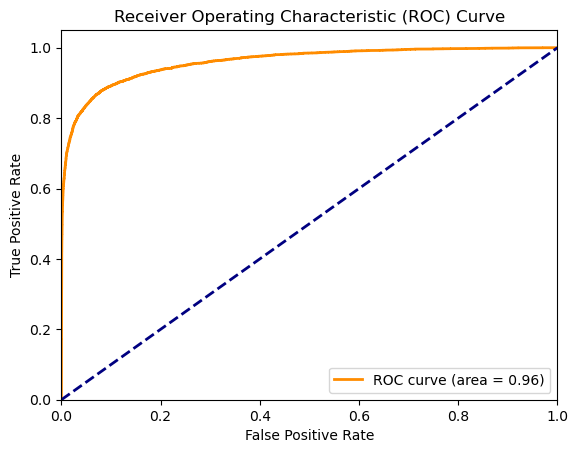

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict the probabilities for the positive class (1)
y_prob_val = xgb_best.predict_proba(X_test)[:, 1]

# Calculate the TPR, FPR, and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_val)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [19]:
import numpy as np
from sklearn.metrics import f1_score

def find_best_threshold(y_true, y_pred, thresholds):
    best_threshold = thresholds[0]
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_threshold = (y_pred > threshold).astype(int)
        current_f1 = f1_score(y_true, y_pred_threshold)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    return best_threshold, best_f1

# Predict probabilities on validation set (assuming you have X_val and y_val)
y_prob_val = xgb_best.predict_proba(X_test)

# Convert y_prob_val to class labels
y_pred_val = y_prob_val[:, 1] #np.argmax(y_prob_val, axis=1)

# Now use y_val and y_pred_val to compute the F1 score
# Find the best threshold
thresholds = np.linspace(0, 1, 100)
best_threshold, best_f1 = find_best_threshold(y_test, y_pred_val, thresholds)
print("Best threshold: ", best_threshold)
print("Best F1 score: ", best_f1)

# Predict probabilities on test set
y_prob_test = xgb_best.predict_proba(X_test)

# Convert the predicted probabilities to class labels using the best threshold
y_pred_test_best_threshold = (y_prob_test[:, 1] > best_threshold).astype(int)

# Performance report
print("Tuned XGBoost Performance with Optimal Threshold:")
print(classification_report(y_test, y_pred_test_best_threshold))


Best threshold:  0.5656565656565657
Best F1 score:  0.8333055231102954
Tuned XGBoost Performance with Optimal Threshold:
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     23801
         1.0       0.86      0.81      0.83      6199

    accuracy                           0.93     30000
   macro avg       0.91      0.89      0.90     30000
weighted avg       0.93      0.93      0.93     30000



**XGBoost wuth AUC**

In [20]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc

# Set up the parameter search space
param_dist = {
    'objective': ['binary:logistic'],
    'scale_pos_weight': [79337 / 20663],
    'max_depth': list(range(3, 11)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=10)),
    'subsample': list(np.linspace(0.1, 1, 10)),
    'colsample_bytree': list(np.linspace(0.1, 1, 10)),
    'n_estimators': [100, 500, 1000]
}

# Create an XGBoost classifier
xgb_clf = xgb.XGBClassifier( eval_metric='logloss')

# Set up the randomized search
random_search = RandomizedSearchCV(
    xgb_clf, 
    param_distributions=param_dist, 
    n_iter=5, 
    scoring='roc_auc', 
    cv=3, 
    random_state=42, 
    verbose=2  # Print scores after each iteration
)

# Perform the randomized search
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

# Train the XGBoost model with the best parameters
xgb_best = xgb.XGBClassifier(**best_params, eval_metric='logloss')
xgb_best.fit(X_train, y_train)

# Predict on test set
y_pred_xgb_best = xgb_best.predict(X_test)

# Performance report
print("Tuned XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb_best))


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END colsample_bytree=1.0, learning_rate=0.2997421251594704, max_depth=7, n_estimators=500, objective=binary:logistic, scale_pos_weight=3.839568310506703, subsample=0.5; total time= 1.5min
[CV] END colsample_bytree=1.0, learning_rate=0.2997421251594704, max_depth=7, n_estimators=500, objective=binary:logistic, scale_pos_weight=3.839568310506703, subsample=0.5; total time= 1.5min
[CV] END colsample_bytree=1.0, learning_rate=0.2997421251594704, max_depth=7, n_estimators=500, objective=binary:logistic, scale_pos_weight=3.839568310506703, subsample=0.5; total time= 1.5min
[CV] END colsample_bytree=0.7000000000000001, learning_rate=0.0645774832507442, max_depth=9, n_estimators=500, objective=binary:logistic, scale_pos_weight=3.839568310506703, subsample=0.6; total time= 1.3min
[CV] END colsample_bytree=0.7000000000000001, learning_rate=0.0645774832507442, max_depth=9, n_estimators=500, objective=binary:logistic, scale_pos_weigh

In [21]:
import pickle

# Save the model to a file
with open("xgb_best_auc.pkl", "wb") as f:
    pickle.dump(xgb_best, f)

# Load the model from the file
with open("xgb_best_auc.pkl", "rb") as f:
    xgb_best = pickle.load(f)



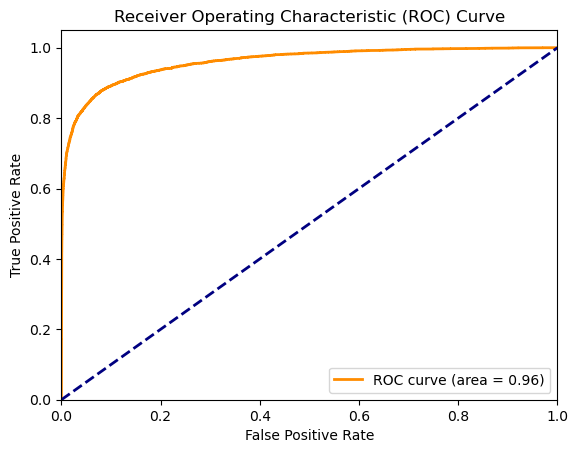

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict the probabilities for the positive class (1)
y_prob_val = xgb_best.predict_proba(X_test)[:, 1]

# Calculate the TPR, FPR, and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_val)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [23]:
import numpy as np
from sklearn.metrics import f1_score

def find_best_threshold(y_true, y_pred, thresholds):
    best_threshold = thresholds[0]
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_threshold = (y_pred > threshold).astype(int)
        current_f1 = f1_score(y_true, y_pred_threshold)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    return best_threshold, best_f1

# Predict probabilities on validation set (assuming you have X_val and y_val)
y_prob_val = xgb_best.predict_proba(X_test)

# Convert y_prob_val to class labels
y_pred_val = y_prob_val[:, 1] #np.argmax(y_prob_val, axis=1)

# Now use y_val and y_pred_val to compute the F1 score
# Find the best threshold
thresholds = np.linspace(0, 1, 100)
best_threshold, best_f1 = find_best_threshold(y_test, y_pred_val, thresholds)
print("Best threshold: ", best_threshold)
print("Best F1 score: ", best_f1)

# Predict probabilities on test set
y_prob_test = xgb_best.predict_proba(X_test)

# Convert the predicted probabilities to class labels using the best threshold
y_pred_test_best_threshold = (y_prob_test[:, 1] > best_threshold).astype(int)

# Performance report
print("Tuned XGBoost Performance with Optimal Threshold:")
print(classification_report(y_test, y_pred_test_best_threshold))


Best threshold:  0.5656565656565657
Best F1 score:  0.8333055231102954
Tuned XGBoost Performance with Optimal Threshold:
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     23801
         1.0       0.86      0.81      0.83      6199

    accuracy                           0.93     30000
   macro avg       0.91      0.89      0.90     30000
weighted avg       0.93      0.93      0.93     30000



**Evaluation**

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc

# def plot_confusion_matrix(y_true, y_pred):
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title('Confusion Matrix')
#     plt.show()

# def plot_roc_auc_curve(y_true, y_prob):
#     fpr, tpr, thresholds = roc_curve(y_true, y_prob)
#     roc_auc = auc(fpr, tpr)
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC)')
#     plt.legend(loc="lower right")
#     plt.show()

# # def evaluate_classification(y_true, y_pred, y_prob):
# #     plot_confusion_matrix(y_true, y_pred)
    
# #     print("Classification Report:")
# #     print(classification_report(y_true, y_pred))
    
# #     plot_roc_auc_curve(y_true, y_prob)


# from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, precision_recall_curve, average_precision_score

# def evaluate_classification(y_true, y_pred, y_prob):
#     plot_confusion_matrix(y_true, y_pred)
    
#     print("Classification Report:")
#     print(classification_report(y_true, y_pred))
    
#     kappa = cohen_kappa_score(y_true, y_pred)
#     print(f"Cohen's Kappa: {kappa:.4f}")
    
#     mcc = matthews_corrcoef(y_true, y_pred)
#     print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    
#     precision, recall, _ = precision_recall_curve(y_true, y_prob)
#     ap = average_precision_score(y_true, y_prob)
#     print(f"Average Precision: {ap:.4f}")
    
#     plot_roc_auc_curve(y_true, y_prob)


In [ ]:
# # Assuming you already have y_true, y_pred, and y_prob from your model
# evaluate_classification(y_true, y_pred, y_prob)
